In [123]:
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import h
from astropy.constants import k_B

T_cmb = 2.7255

mpl.rcParams['text.usetex'] = True

In [124]:
def cmb_to_rj(freq,data):
    y          = h.value*(freq*1e9)/ (k_B.value*T_cmb)
    conversion = (y**2.0*np.exp(y))/(np.exp(y)-1)**2.0
    return data*conversion

In [125]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    # Inputs need to be in GHz.
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

In [126]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_Q_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_Q_scaled[i]   = np.nan
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_U_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_U_scaled[i]   = np.nan
        elif (pol == 'P'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_P_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_P_scaled[i]   = np.nan
        else:
            print("Unusable pol type (use 'Q', 'U', or 'P').")
            
def sky_frac(map):
    masked = 0
    for i in range(len(map)):
        if (map[i] == hp.UNSEEN):
            masked += 1
            
    print('Sky fraction: ', 1.-masked/len(map))

In [127]:
dir = str(input('Which directory are we wanting to plot from? '))

Which directory are we wanting to plot from?  bp7.00_v18


In [128]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2))
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2))
synch_Q_030  = hp.read_map('../'+dir+'/bp_030_synch_amplitude_Q_00020.fits')
synch_U_030  = hp.read_map('../'+dir+'/bp_030_synch_amplitude_U_00020.fits')
dust_Q_amps  = np.loadtxt('../'+dir+'/dust_Q_amplitudes.dat')
dust_Q_unc   = np.loadtxt('../'+dir+'/dust_Q_uncertainties.dat')
dust_U_amps  = np.loadtxt('../'+dir+'/dust_U_amplitudes.dat')
dust_U_unc   = np.loadtxt('../'+dir+'/dust_U_uncertainties.dat')
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0)

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [129]:
def read_params(filename):
    labels = []
    freq   = []
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('NUMBAND'):
                numbands = int(line.split('=')[1])
                
    blabs = []
    bfreq = []
    for band in range(numbands):
        blabs.append('BAND_LABEL'+str(band+1).zfill(2))
        bfreq.append('BAND_FREQ'+str(band+1).zfill(2))        
    for band in range(numbands):
         with open(filename,'r') as infile:
            for line in infile:
                if line.startswith(blabs[band]):
                    name = str.strip(line.split('=')[1])
                    labels.append(name)
                if line.startswith(bfreq[band]):
                    fre  = str.strip(line.split('=')[1])
                    freq.append(float(fre))
    return labels, freq

In [130]:
names, freq = read_params('../'+dir+'/param_'+dir+'.txt')
labels = [name.replace("'","") for name in names]
labels = [w.replace("_","\_") for w in labels]
print(labels)
print(freq)

['bp\\_030', 'bp\\_044', 'bp\\_070', 'wmap\\_Ka', 'wmap\\_Q']
[28.4, 44.1, 70.3, 33.0, 40.6]


In [131]:
# Define bands - labels and frequencies
# freq         = [28.4, 44.1, 70.3, 33.0, 40.6]
# labels       = ['bp\_030','bp\_044','bp\_070','WMAP\_Ka','WMAP\_Q']

In [132]:
# Planck 2015 2 component AME details
ame_comp1 = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2 = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz

In [133]:
# Some plotting array of frequencies
x = np.linspace(5,1000,1000)

In [134]:
dust_353     = cmb_to_rj(353,dust_353)
dust_353_rms = cmb_to_rj(353,dust_353_rms)

In [135]:
dust_353_P  = np.empty(len(synch_Q_030))
dust_P_rms  = np.empty(len(synch_Q_030))
synch_P_030 = np.empty(len(synch_Q_030))
dust_P_amps = np.empty(len(dust_Q_amps[0]))
dust_P_unc  = np.empty(len(dust_Q_unc))

for i in range(len(synch_Q_030)):
    dust_353_P[i]  = np.sqrt(dust_353[1][i]**2 + dust_353[2][i]**2)
    dust_P_rms[i]  = np.sqrt(dust_353_rms[1][i]**2 + dust_353_rms[2][i]**2)
    synch_P_030[i] = np.sqrt(synch_Q_030[i]**2 + synch_U_030[i]**2)
    
for i in range(len(dust_P_amps)):
    dust_P_amps[i] = np.sqrt(dust_Q_amps[0,i]**2 + dust_U_amps[0,i]**2)
    
for i in range(len(dust_Q_unc)):
    dust_P_unc[i] = np.sqrt(dust_Q_unc[i]**2 + dust_U_unc[i]**2)

In [136]:
# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.
mono_dip       = hp.remove_dipole(dust_353[0][:],gal_cut=75,fitval=True)
print(mono_dip[1])
dust_353[0][:] = hp.remove_dipole(dust_353[0][:],gal_cut=75) + mono_dip[1]

synch_Q_scaled = synch_Q_030/dust_353[1][:]
synch_U_scaled = synch_U_030/dust_353[2][:]
synch_P_scaled = synch_P_030/dust_353_P

monopole: 49.6207  dipole: lon: -96.5856, lat: 46.3103, amp: 273.381
49.620705942608836
monopole: 49.6207  dipole: lon: -96.5856, lat: 46.3103, amp: 273.381


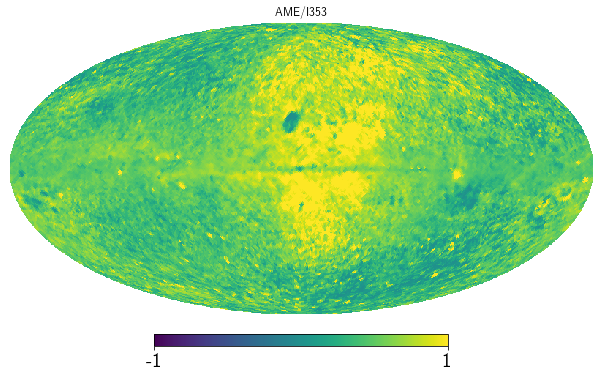

0.5112263157678931


In [137]:
# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course

I_ame_over_I_353    = ame_map/dust_353[0][:]
hp.mollview(I_ame_over_I_353,min=-1,max=1,title='AME/I353')
plt.savefig('../ame_over_I353',dpi=300,bbox_inches='tight')
plt.show()
print(np.median(I_ame_over_I_353))

In [138]:
# Make signal to noise maps 
s_n_Q        = dust_353[1][:]/dust_353_rms[1][:]
s_n_U        = dust_353[2][:]/dust_353_rms[2][:]
s_n_P        = dust_353_P/dust_P_rms
mask_Q       = np.empty(len(s_n_Q))
mask_U       = np.empty(len(s_n_U))
mask_P       = np.empty(len(s_n_P))

# Write something here about choosing a pixel, or s/n ratio for a sky fraction

sn_lim = float(input('Signal to noise limit: '))

npix = len(synch_Q_030)
Q_masked = 0
U_masked = 0
P_masked = 0

Signal to noise limit:  10


In [139]:
for i in range(len(s_n_Q)):
    if (np.abs(s_n_Q[i]) > sn_lim):
        mask_Q[i] = 1.0
    else:
        Q_masked += 1
        mask_Q[i] = hp.UNSEEN
        s_n_Q[i]  = hp.UNSEEN

    if (np.abs(s_n_U[i]) > sn_lim):
        mask_U[i] = 1.0
    else:
        U_masked += 1
        mask_U[i] = hp.UNSEEN
        s_n_U[i]  = hp.UNSEEN
        
    if (np.abs(s_n_P[i]) > sn_lim):
        mask_P[i] = 1.0
    else:
        P_masked += 1
        mask_P[i] = hp.UNSEEN
        s_n_P[i]  = hp.UNSEEN

In [148]:
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

Sky fraction:  0.35308837890625
Sky fraction:  0.24070231119791663
Sky fraction:  0.35109456380208337


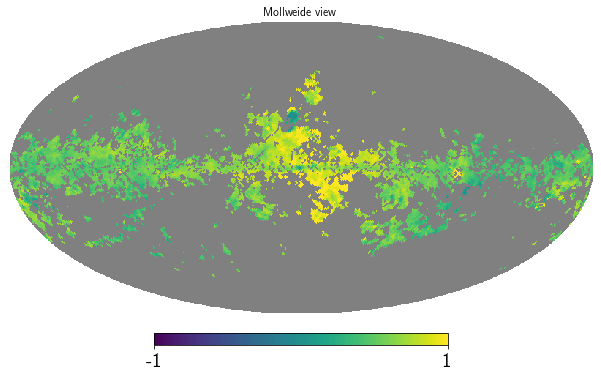

0.5689430158981534
0.5960158894196828


In [149]:
mask_maps(mask_Q,'Q')
sky_frac(mask_Q)
mask_maps(mask_U,'U')
sky_frac(mask_U)
mask_maps(mask_P,'P')
sky_frac(mask_P)

hp.mollview(I_ame_over_I_353,min=-1,max=1)
plt.show()

ame_over_353_median = np.nanmedian(I_ame_over_I_353)
ame_over_353_mean   = np.nanmean(I_ame_over_I_353)
print(ame_over_353_median)
print(ame_over_353_mean)
spdust_tot *= ame_over_353_mean


In [150]:
# ame_col = ['yellow','gold','orange','darkorange','orangered']
ame_col = ['goldenrod','orange','darkorange','chocolate','saddlebrown']
amp_col = ['royalblue','cadetblue','steelblue','darkturquoise','cyan']

In [151]:
s_Q_mean = np.nanmean(synch_Q_scaled)
s_Q_std  = np.nanstd(synch_Q_scaled)
s_Q_low  = s_Q_mean - s_Q_std
s_Q_high = s_Q_mean + s_Q_std
print("Q",s_Q_low,s_Q_high)

s_U_mean = np.nanmean(synch_U_scaled)
s_U_std  = np.nanstd(synch_U_scaled)
s_U_low  = s_U_mean - s_U_std
s_U_high = s_U_mean + s_U_std
print("U",s_U_low,s_U_high)

s_P_mean = np.nanmean(synch_P_scaled)
s_P_std  = np.nanstd(synch_P_scaled)
s_P_low  = s_P_mean - s_P_std
s_P_high = s_P_mean + s_P_std
print("P",s_P_low,s_P_high)

Q -0.5947881274625041 2.1422620776875165
U -1.2789797931666014 2.3502396771727794
P 0.1024246436368359 2.2878262479056235


In [152]:
def plot_Q_Q353():
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_Q_mean,30.0,x,-3.1),color='green',label='Synch')
#     ax.plot(x,power_law(s_Q_high,30.0,x,-3.1),color='green',linestyle='--')
#     ax.fill_between(x,power_law(s_Q_low,30.0,x,-3.1),power_law(s_Q_high,30.0,x,-3.1),color='Green',alpha=0.2)
    ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label='Thermal Dust')
#     ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = p_{\mathrm{dust}}^{max}$')
#     ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 0.5*p_{\mathrm{dust}}^{max}$')
#     ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 0.25*p_{\mathrm{dust}}^{max}$')
#     ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 0.1*p_{\mathrm{dust}}^{max}$')
#     ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 0.05*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    k = 0
    for j in range(len(freq)):
        if dust_Q_amps[0][j] == 0.0:
            continue
        else:
            ax.scatter(freq[j],dust_Q_amps[0,j],label=labels[j],color=amp_col[k],zorder=10)
            ax.errorbar(freq[j],dust_Q_amps[0,j],dust_Q_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.set_xlim([5,353])
    ax.set_ylim([1e-4,1e2])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('AME Pol v18 - Q Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$Q/Q_{353}$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency [GHz]}$',size=20)
    ax.legend(loc=1, prop={'size': 15})
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
#     plt.savefig('../'+dir+'/sed_fgs_Q353.pdf',dpi=300,bbox_inches='tight')
    plt.savefig('../sed_fgs_Q353.pdf',dpi=300,bbox_inches='tight')
    plt.show()

def plot_U_U353():
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(np.mean(synch_U_scaled),30.0,x,-3.1),color='green',label='Synch')
#     ax.fill_between(x,power_law(s_U_low,30.0,x,-3.1),power_law(s_U_high,30.0,x,-3.1),color='Green',alpha=0.2)
    ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label='Thermal Dust')
    ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    k = 0
    for j in range(len(freq)):
        if dust_U_amps[0][j] == 0.0:
            continue
        else:
            ax.scatter(freq[j],dust_U_amps[0,j],label=labels[j],color=amp_col[k],zorder=10)
            ax.errorbar(freq[j],dust_U_amps[0,j],dust_U_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.set_xlim([5,353])
    ax.set_ylim([1e-4,1e2])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('AME Pol v18 - U Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$U/U_{353}$',size=20)
    ax.set_xlabel('Frequency [GHz]',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_U353.pdf',dpi=300,bbox_inches='tight')
    plt.show()
    
def plot_P_P353():
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(np.mean(synch_P_scaled),30.0,x,-3.1),color='green',label='Synch')
#     ax.fill_between(x,power_law(s_P_low,30.0,x,-3.1),power_law(s_P_high,30.0,x,-3.1),color='Green',alpha=0.2)
    ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label='Thermal Dust')
    ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    k = 0
    for j in range(len(freq)):
        if dust_U_amps[0][j] == 0.0:
            continue
        else:
            ax.scatter(freq[j],dust_P_amps[j],label=labels[j],color=amp_col[k],zorder=10)
            ax.errorbar(freq[j],dust_P_amps[j],dust_P_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.set_xlim([5,353])
    ax.set_ylim([1e-4,1e2])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('AME Pol v18 - P Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$P/P_{353}$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency [GHz]}$',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_P353.pdf',dpi=300,bbox_inches='tight')
    plt.show()    

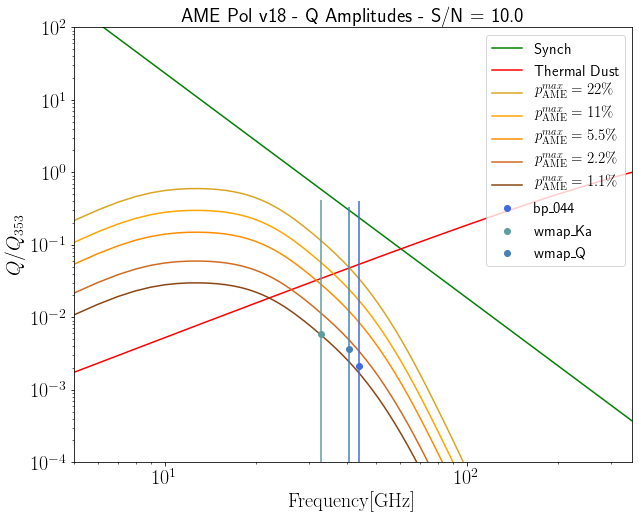

In [153]:
plot_Q_Q353()

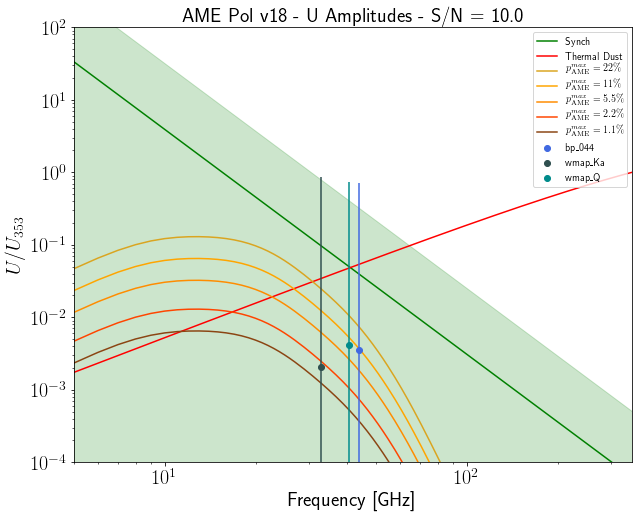

In [70]:
plot_U_U353()

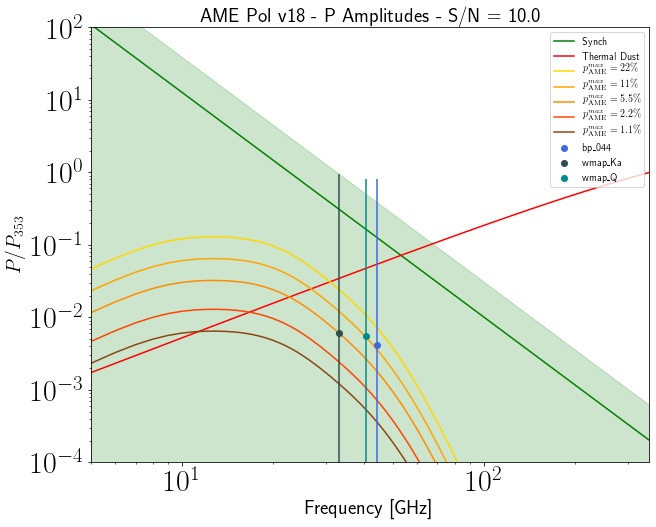

In [61]:
plot_P_P353()